In [91]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skewnorm
#from IPython.display import Image
#from scipy import stats
import random


%matplotlib inline

### Assumptions

In [92]:
#creating data frame wit assumptions

#assumptions on dictionary
assumptions = dict()
columns_name = ['type','low', 'mid', 'high', 'max', 'min']
assumptions['peak_whoppers'] = ['discrete',2,3,4,10,0]
assumptions['lazy_whoppers'] = ['discrete',0,1,2,5,0] 
assumptions['hours_day'] = ['discrete',10,12,12,13,8]
assumptions['peak_hours'] = ['discrete',2,4,5,8,2]
assumptions['days_year'] = ['discrete',252,350,365,366,250]
assumptions['num_rest'] = ['discrete',890,907,911,920,800]
assumptions['price'] = ['continuous',12.9,35.0,42,57.0,12.9]

#converting dictionary to data frame
assumptions_df = pd.DataFrame().from_dict(assumptions,orient='index',columns=columns_name)
assumptions_df
     

,type,low,mid,high,max,min
peak_whoppers,discrete,2.0,3.0,4,10.0,0.0
lazy_whoppers,discrete,0.0,1.0,2,5.0,0.0
hours_day,discrete,10.0,12.0,12,13.0,8.0
peak_hours,discrete,2.0,4.0,5,8.0,2.0
days_year,discrete,252.0,350.0,365,366.0,250.0
num_rest,discrete,890.0,907.0,911,920.0,800.0
price,continuous,12.9,35.0,42,57.0,12.9


### Base Case Market Sizing

In [93]:
def market_sizing(peak_whoppers,lazy_whoppers, hours_day,peak_hours, days_year, num_rest, price):
    ''' 
    Input: assumptions
    Process: market sizing logic
    Output: Market size
    '''
    whoppers_peak_hours = peak_whoppers * peak_hours
    lazy_hours = hours_day - peak_hours
    whoppers_lazy_hours = lazy_whoppers * lazy_hours
    whoppers_day = whoppers_peak_hours + whoppers_lazy_hours
    whoppers_rest_year = whoppers_day * days_year
    whoppers_year = whoppers_rest_year * num_rest
    rev_year = whoppers_year * price
    return rev_year

In [94]:
#generate base case

#retrieve base case assumptions
base_assumptions = assumptions_df['mid'].tolist()

#determine market size with market_sizing function
base_case_mkt_size = market_sizing(base_assumptions[0],base_assumptions[1],base_assumptions[2],base_assumptions[3],base_assumptions[4],base_assumptions[5], base_assumptions[6])

print(f'The base case market size is: R$ {round(base_case_mkt_size/1000000)}MM')

The base case market size is: R$ 222MM


### Generating Scenarios (Monte Carlo Simulation)

The parameters we need for a monte carlo simulation are: mean, standard deviation and skewness
From the low, mid and high values we can calculate an standard deviation and the skewness, which will be the difference between the high-case and low-case values by the mean. The primary reason for using this approach is to normalize the skewness measure and make it more interpretable (a skewness value of 0.05 means that the high-case value is 5% greater than the low-case value relative to the mean) and meaningful, especially when dealing with different scales and units of measurement.

In [95]:
def montecarlo_var(x_low, x_mid, x_high):
    
    distr_mean = x_mid
    
    #z-values for p10 and p90
    z_10 = stats.norm.ppf(0.1)
    z_90 = stats.norm.ppf(0.9)
    
    #standard deviations for p10 and p90
    stdev10 = (x_low - x_mid) / z_10
    stdev90 = (x_high - x_mid) / z_90
    
    #average standard deviation
    avg_stdev = np.mean((stdev10,stdev90))
    scale = avg_stdev
    
    #skewness
    diff_high = (x_high-x_mid) / x_mid 
    diff_low = (x_mid - x_low) / x_mid
    a = (diff_high - diff_low) / x_mid
    
    return distr_mean, scale, a

In [113]:
def montecarlo_data(distr_mean, scale, a, n, max_val, min_val, discrete=False):
    #number of simulations:
    '''
    we will calculates the number of simulations to generate, n_sim, which is double than the specified n. 
    This is because we intend to remove simulations that fall outside the min_val and max_val filters later.  
    '''
    n_sim = np.int32(n * 2)
    
    #generate distribution:
    sim_data = skewnorm(a,distr_mean,scale).rvs(n_sim)
    
    #apply max/min filters
    sim_data = [num for num in sim_data if num <= max_val]
    sim_data = [num for num in sim_data if num >= min_val]
    
    
    #if variable is discrete, then round the result to the nearest integer
    if discrete == True: 
        sim_data = [int(round(a,0)) for a in sim_data]
    
    #retrieve only n from sim_data
    random.shuffle(sim_data)
    sim_data = sim_data[0:n]
    
    return sim_data

C:\Users\biby_\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


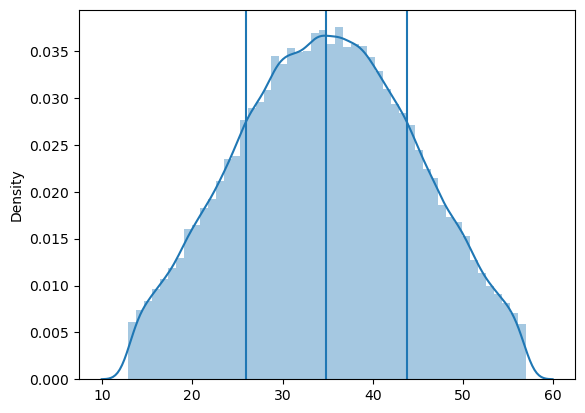

In [114]:
#testing it with a particular variable from assumptions_df
var_test = 'price'

x_var = assumptions_df.loc[var_test].tolist()
distr_mean, scale, a = montecarlo_var(x_var[1],x_var[2],x_var[3])

max_val = assumptions_df.loc[var_test, 'max']
min_val = assumptions_df.loc[var_test, 'min']

discrete=False
if assumptions_df.loc[var_test,'type'] == 'discrete':
    discrete = True

data_test = montecarlo_data(distr_mean,scale,a,n=100000,max_val = max_val, min_val = min_val, discrete=discrete)

#visualization
sns.distplot(data_test)
plt.axvline(np.percentile(data_test,20))
plt.axvline(np.percentile(data_test,80))
plt.axvline(np.percentile(data_test,50))

In [115]:
#monte carlo for all assumptions
monte_all = pd.DataFrame()

#create a placeholder DataFrame with the expected length
expected_length = 100000

for column in assumptions_df.index:
    monte_all[column] = [np.nan] * expected_length

for column in assumptions_df.index:
    x_var = assumptions_df.loc[column].tolist()
    distr_mean, scale, a = montecarlo_var(x_var[1], x_var[2], x_var[3])

    max_val = assumptions_df.loc[column, 'max']
    min_val = assumptions_df.loc[column, 'min']
    
    discrete=False
    if assumptions_df.loc[column, 'type'] == 'discrete':
        discrete = True

    monte_sim = montecarlo_data(distr_mean, scale, a, n=expected_length, max_val=max_val, min_val=min_val, discrete=discrete)

    #fill the corresponding column with the generated values
    if len(monte_sim) < expected_length:
        monte_sim.extend([np.nan] * (expected_length - len(monte_sim)))
    monte_all[column] = monte_sim

monte_all.head()

,peak_whoppers,lazy_whoppers,hours_day,peak_hours,days_year,num_rest,price
0,3,2,11,3,313,911,26.816809
1,2,0,12,4,258,897,45.151170
2,3,2,12,2,361,912,49.535368
3,2,1,11,4,345,899,30.173879
4,3,1,11,3,358,907,52.949125


C:\Users\biby_\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\biby_\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\biby_\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-lev

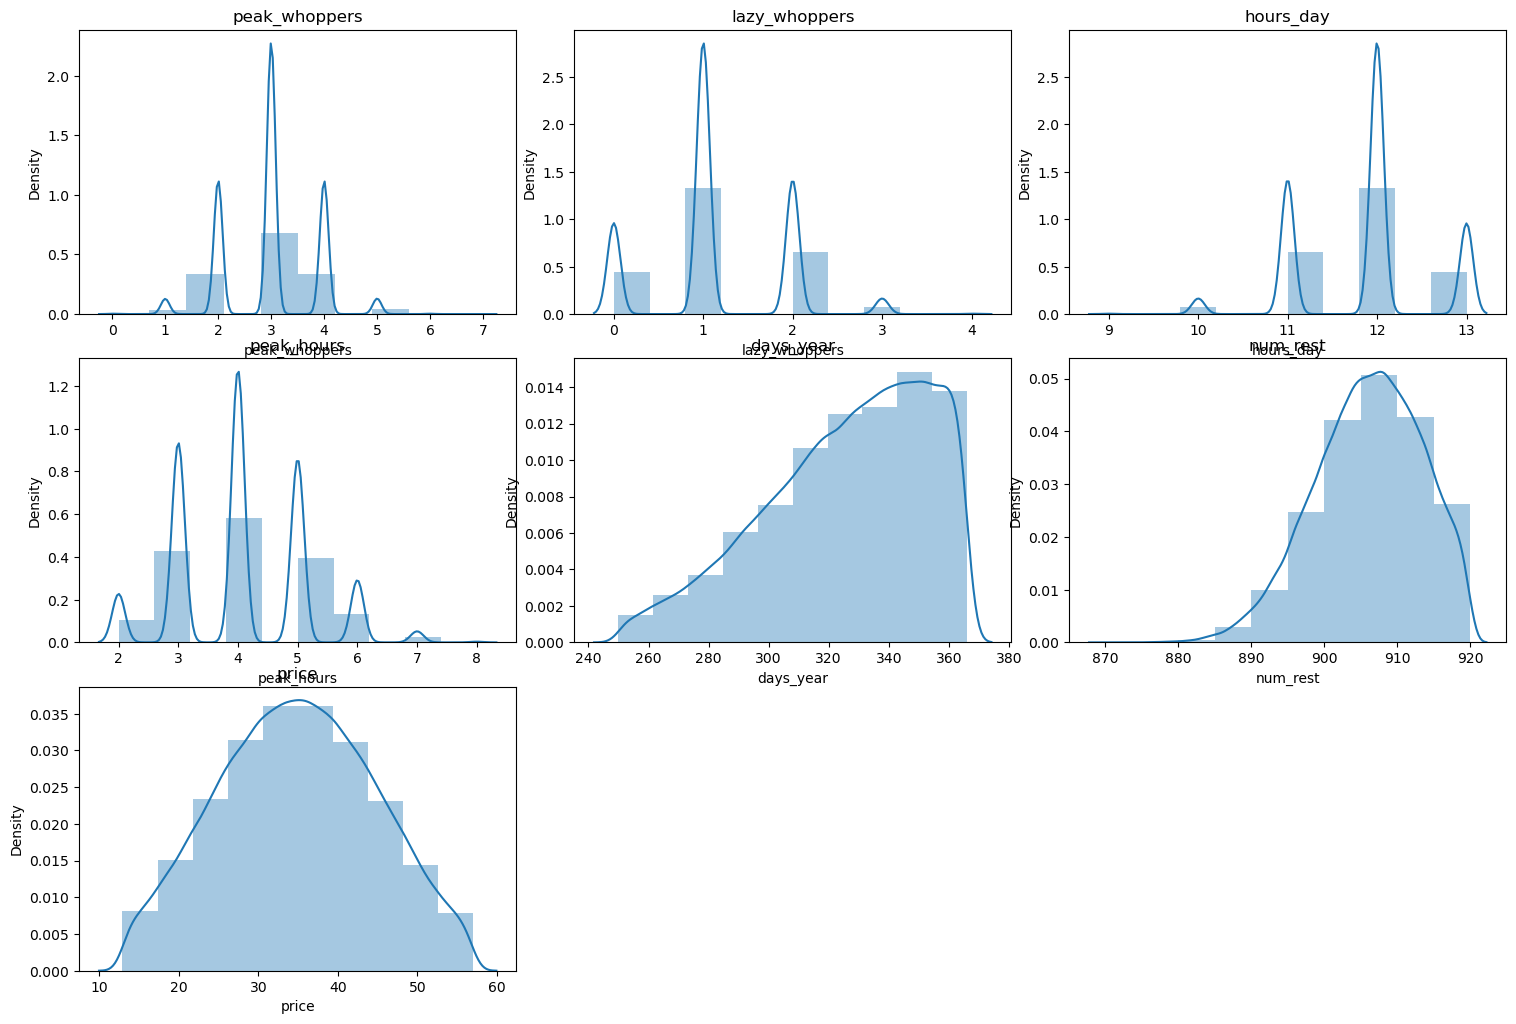

In [116]:
#visualization of all variables
    
#determine the number of rows and columns for subplots
num_variables = len(monte_all.columns)
num_rows = 3  # You want 3 rows
num_cols = (num_variables + num_rows - 1) // num_rows

#create subplots
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(15, 10))
fig.tight_layout()

#plot the distributions
for i, column in enumerate(monte_all.columns):
    sns.distplot(monte_all[column], bins=10, ax=axes[i // num_cols, i % num_cols])
    axes[i // num_cols, i % num_cols].set_title(column)

#hide any remaining empty subplots
for i in range(num_variables, num_rows * num_cols):
    fig.delaxes(axes[i // num_cols, i % num_cols])

plt.show()


### Calculating Market Size

In [117]:
#using market sizing function for each scenerio, generating a new column
monte_all['market_size_MM_BRL'] = market_sizing(monte_all.peak_whoppers,monte_all.lazy_whoppers,monte_all.hours_day,monte_all.peak_hours,monte_all.days_year,monte_all.num_rest,monte_all.price) / 1000000

In [118]:
#displaying results of market size
monte_all.head()

,peak_whoppers,lazy_whoppers,hours_day,peak_hours,days_year,num_rest,price,market_size_MM_BRL
0,3,2,11,3,313,911,26.816809,191.165635
1,2,0,12,4,258,897,45.151170,83.593237
2,3,2,12,2,361,912,49.535368,424.024332
3,2,1,11,4,345,899,30.173879,140.378693
4,3,1,11,3,358,907,52.949125,292.279278


C:\Users\biby_\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


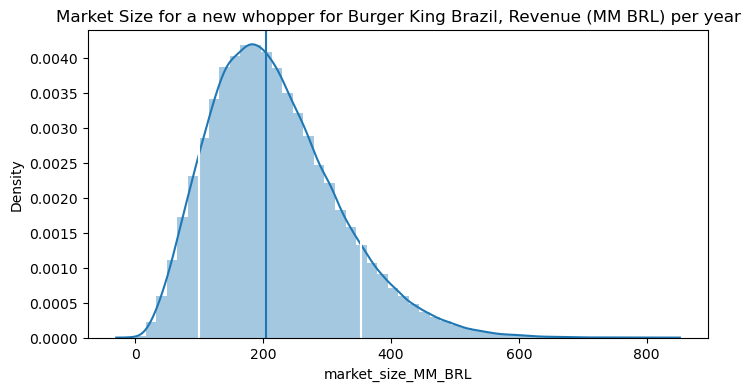

In [121]:
#visualizing the resulting market size of the n simulations 

plt.figure(figsize=(8,4))

vis_data = monte_all['market_size_MM_BRL']
sns.distplot(vis_data)
plt.axvline(np.percentile(vis_data,10),color='w')
plt.axvline(np.percentile(vis_data,90),color='w')
plt.axvline(np.percentile(vis_data,50))

plt.title('Market Size for a new whopper for Burger King Brazil, Revenue (MM BRL) per year')
plt.savefig('msize.png')

In [122]:
#print results
base_avg = round(vis_data.median(),2)
print(f'Median Market size is : {base_avg} MM BRL')
print(f'It is unlikely (less than 10% probability), that the market is less than : {round(np.percentile(vis_data,10),1)} MM BRL')
print(f'It is unlikely (more than 10% probability), that the market is more than : {round(np.percentile(vis_data,90),1)} MM BRL')

Median Market size is : 204.68 MM BRL
It is unlikely (less than 10% probability), that the market is less than : 99.1 MM BRL
It is unlikely (more than 10% probability), that the market is more than : 352.5 MM BRL


### Feature sensitivity

All else being equal, how does the market size change when I change the (variable)?
For example: with everything else constant in each of the simulations, how does the market size (median) change when I price the lowest value, then the average, then the highest?
To answer this question, we will follow the following logic:
1. get the original simulation data frame
2. change the -price- column to the lowest value for all lines (simulations)
3. recalculate the market size for all lines
4. store the median market size
5. repeat steps 2-4 for the mid price and the highest price.
6. store these three values in a dictionary
7. repeat steps 1-6 for each of the remaining variables in a for loop
8. save the size of this market size variation as width


In [129]:
#copying data frame, just in case
monte_backup = monte_all.copy()

In [143]:
sensitivity_dict = dict()

for variable in assumptions_df.index:
    # 1. reset to the original simulations
    monte_sensitivity = monte_all.copy()

    # 2. change the variable column to the lowest value in all lines
    monte_sensitivity[variable] = assumptions_df.loc[variable,'low']
    
    # 3. recalculate the market size
    monte_sensitivity['market_size_sensitivity'] = market_sizing(monte_sensitivity.peak_whoppers,monte_sensitivity.lazy_whoppers,monte_sensitivity.hours_day,monte_sensitivity.peak_hours,monte_sensitivity.days_year,monte_sensitivity.num_rest,monte_sensitivity.price) / 1000000
    
    # 4. store the median market size
    sensitivity_market_size_low = monte_sensitivity['market_size_sensitivity'].median() 
    
    # 5. repeat steps 2-4 for the mid and the highest value.
    
    #mid
    monte_sensitivity[variable] = assumptions_df.loc[variable,'mid']
    monte_sensitivity['market_size_sensitivity'] = market_sizing(monte_sensitivity.peak_whoppers,monte_sensitivity.lazy_whoppers,monte_sensitivity.hours_day,monte_sensitivity.peak_hours,monte_sensitivity.days_year,monte_sensitivity.num_rest,monte_sensitivity.price) / 1000000
    sensitivity_market_size_mid = monte_sensitivity['market_size_sensitivity'].median() 
    
    #high
    monte_sensitivity[variable] = assumptions_df.loc[variable,'high']
    monte_sensitivity['market_size_sensitivity'] = market_sizing(monte_sensitivity.peak_whoppers,monte_sensitivity.lazy_whoppers,monte_sensitivity.hours_day,monte_sensitivity.peak_hours,monte_sensitivity.days_year,monte_sensitivity.num_rest,monte_sensitivity.price) / 1000000
    sensitivity_market_size_high = monte_sensitivity['market_size_sensitivity'].median() 
    
    # 6. store this three values in a dictionary
    sensitivity_dict[variable] = sensitivity_market_size_low, sensitivity_market_size_mid, sensitivity_market_size_high
    
    # 7. repeat steps 1-6 for each of the remaining variables in a for loop
    
# 8. save the size of this market size variation as width    
sensitivity_df = pd.DataFrame().from_dict(sensitivity_dict,orient='index',columns=['market_size_low','market_size_mid','market_size_high'])
sensitivity_df['baseline'] = base_avg
sensitivity_df['width'] = sensitivity_df.market_size_high - sensitivity_df.market_size_low

sensitivity_df

,market_size_low,market_size_mid,market_size_high,baseline,width
peak_whoppers,166.291018,207.246177,248.301342,204.68,82.010324
lazy_whoppers,114.430222,197.213073,278.905795,204.68,164.475574
hours_day,184.819260,206.523904,206.523904,204.68,21.704643
peak_hours,166.630210,203.549037,222.884768,204.68,56.254558
days_year,159.136539,221.022970,230.495383,204.68,71.358845
num_rest,201.037232,204.877269,205.780807,204.68,4.743575
price,79.059456,214.502400,257.402880,204.68,178.343424


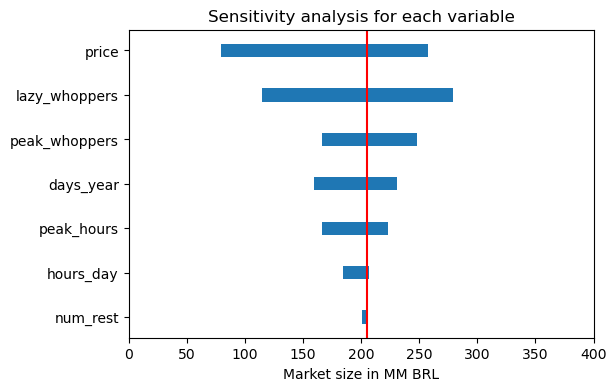

In [148]:
#sort the df by 'width' in descending order
sensitivity_df_sorted = sensitivity_df.sort_values(by='width', ascending=True)

#extract the sorted data for plotting
width = sensitivity_df_sorted.width.tolist()
left = sensitivity_df_sorted.market_size_low.tolist()
labels = sensitivity_df_sorted.index.tolist()

#create a list of y-values for the sorted data
y = range(0, sensitivity_df_sorted.shape[0]) #number of variables

#create the bar plot with the widest bars at the top
fig, ax = plt.subplots(figsize=(6, 4))
ax.barh(width=width, left=left, height=0.3, y=y)

#set the y-tick labels based on the sorted order
ax.set_yticks(range(len(labels)))
ax.set_yticklabels(labels)

plt.xlim([0, 400])
plt.axvline(base_avg, color='red')
plt.title('Sensitivity analysis for each variable')
plt.xlabel('Market size in MM BRL')
plt.show()

Intuitively, the greater the variability in price, the greater the variability in market size. In other words, the greater the uncertainty we have about the price at which we will sell our new whopper, the greater the risk of our investment, followed by how many whoppers we sell at off-peak hours, at peak hours, and so on.